In [91]:
from utils_v1 import *


In [92]:
from icecream import ic

import numpy as np
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates, PatchesHandlerEvidential

from src.trainer.evidential import TrainerEvidential
import src.trainer.evidential as evidential

from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2
from src import metrics as _metric


In [93]:
from enum import Enum
UncertaintyMethod = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single evidential')
uncertaintyMethod = "evidential"


In [94]:

config = {
	"training": False,
	"learning_rate": 1e-4, # 1e-3
	#"learning_rate": 1e-5, # 1e-3	
	"weights": [0.1, 0.9, 0],
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 1,
	"Uncertainty": {
		"annealing_step": 10*375 # 1875, 10*375*10
	},
	"uncertainty_method": uncertaintyMethod,
	"evidence_function": evidential.relu_evidence
}

'''
if config["training"] == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if config["training"] == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
dates = [2018, 2019]
dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = config['addPastDeforestationInput'],
	borderBuffer = 2)	
# dates = [2019, 2020]
# dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = config['addPastDeforestationInput'],
# 	borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]

ic(dates)


if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerEvidential(
		dataset)
else:
	patchesHandler = PatchesHandler()

# exp = 170
# exp = 155
exp = 176



# if config["training"] == True:
trainer = TrainerEvidential(config, dataset, patchesHandler)

trainer.defineExperiment(exp)


ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2018, 2019]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [95]:
exp

176

In [96]:
trainer.setExperimentPath()
trainer.createLogFolders()

In [97]:
# ic(type(dataset), exp, dataset.dates)


In [98]:

trainer.loadLabel()

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [99]:

# Creating tile mask
trainer.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [100]:

trainer.label_mask.dtype

dtype('uint8')

In [101]:

trainer.getLabelCurrentDeforestation()

In [102]:

trainer.loadInputImage()

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [103]:

np.unique(trainer.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

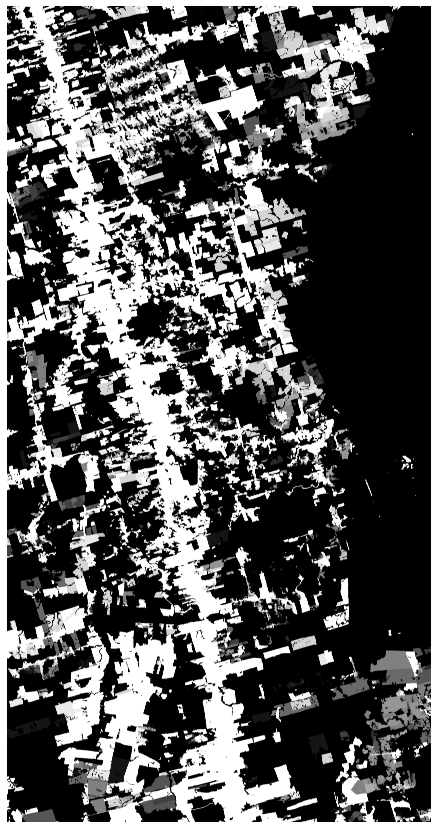

In [104]:

trainer.logger.plotFigure(trainer.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [105]:

trainer.getImageChannels()

ic| self.image_stack.shape: (17730, 9200, 21)
ic| self.channels: 21


In [106]:

trainer.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [107]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    trainer.createIdxImage()


In [108]:
if config["training"] == True:
    trainer.extractCoords()

In [109]:
if config["training"] == True:
    trainer.trainTestSplit()

In [110]:
if config["training"] == True:
    trainer.label_mask.shape

In [111]:
if config["training"] == True:
    if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)

    else:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)



In [112]:
if config["training"] == True:
    np.unique(trainer.label_mask)

In [113]:
if config["training"] == True:
    print(trainer.coords_train)

In [114]:
if config["training"] == True:
    trainer.retrieveSamplesOfInterest()

In [115]:
if config["training"] == True:
    inputSnipShow = True

In [116]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 2800)


In [117]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 97)


In [118]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 1200)

In [119]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 400)

In [120]:
if config["training"] == True:
    trainer.getGenerators()


In [121]:
if config["training"] == True:
    trainer.fixChannelNumber()

In [122]:
if config["training"] == True:
    print(trainer.path_exp)

In [123]:
if config["training"] == True:
    print(trainer.channels)

In [124]:
if config["training"] == True:
    print(trainer.image_stack.shape)

In [125]:
# trainer.weights = [0.01, 0.99, 0]
trainer.weights

[0.1, 0.9, 0]

### Evidential metrics

In [126]:
if config["training"] == True:
    trainer.train()

In [127]:
if config["training"] == True:
    trainer.plotHistory()


In [128]:
if config["training"] == True:
    trainer.plotLossTerms()

In [129]:
if config["training"] == True:
    trainer.plotAnnealingCoef()

In [130]:
def draw_EDL_results(K, history):
    # train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    '''
    K: known classes
    '''
    train_u_succ = K / (K+np.array(history['evidential_success']))
    train_u_fail = K / (K+np.array(history['evidential_fail']))
    test_u_succ  = K / (K+np.array(history['val_evidential_success']))
    test_u_fail  = K / (K+np.array(history['val_evidential_fail']))
    
    f, axs = plt.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(history['evidential_success'],c='r',marker='+')
    axs[0,0].plot(history['evidential_fail'],c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(history['acc'],c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(history['val_evidential_success'],c='r',marker='+')
    axs[1,0].plot(history['val_evidential_fail'],c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(history['val_acc'],c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    

In [131]:
if config["training"] == True:
    draw_EDL_results(trainer.class_n, trainer.history.history)

    plt.figure(5)
    plt.plot(trainer.history.history['evidential_success'],c='r',marker='+')
    plt.plot(trainer.history.history['evidential_fail'],c='k',marker='x')
    plt.title('Train Data')
    plt.xlabel('Epoch')
    plt.ylabel('Estimated total evidence for classification') 
    plt.legend(['Correct Clasifications','Misclasifications'])


In [132]:
trainer.image_stack.shape

(17730, 9200, 21)

In [133]:
if type(trainer.dataset) != PADeforestationTime and type(trainer.dataset) != MTDeforestationTime:
    trainer.patchesHandler.dataset.image_channels[-1]

In [134]:
if issubclass(type(dataset), MultipleDates):
	trainer.channels = trainer.patchesHandler.input_image_shape
	trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
	trainer.label_mask = trainer.label_mask[...,-1]

In [135]:
trainer.image_stack.shape

(17730, 9200, 21)

In [136]:
trainer.setPadding()

-30.0 -16.0


In [137]:
trainer.infer()

ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp176/models/resunet_0.h5'


time:  0


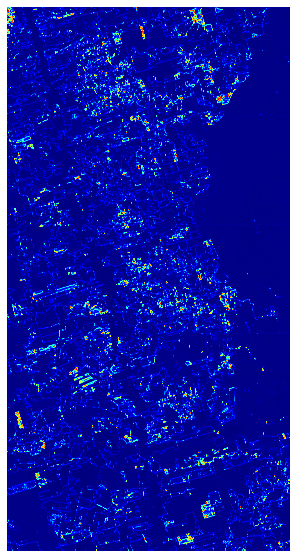

In [138]:
trainer.logger.plotFigure(trainer.u_reconstructed, 
            name='Uncertainty', cmap='jet', savefig=False, figsize=(10,10))

In [139]:
trainer.loadPredictedProbabilities()


In [140]:
trainer.prob_rec.shape

(17760, 9216)

In [141]:
trainer.getMeanProb()

In [142]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0027935621
    np.mean(value): 0.024964368
    np.max(value): 0.9725021


In [143]:
ic(trainer.mean_prob.shape)

ic| trainer.mean_prob.shape: (17760, 9216)


(17760, 9216)

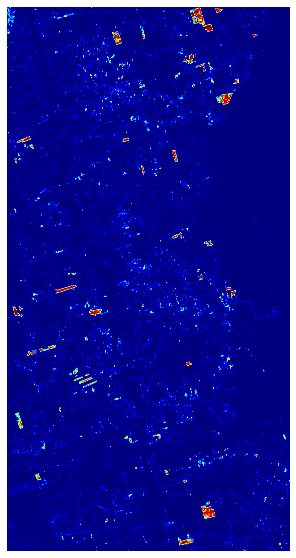

In [144]:
trainer.unpadMeanProb()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

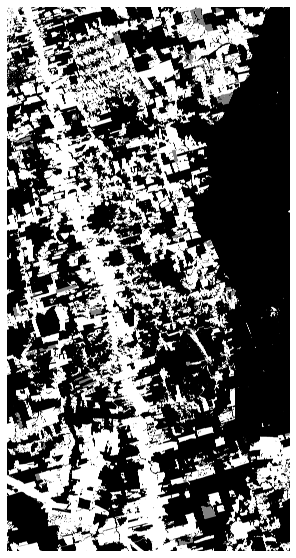

In [145]:
trainer.logger.plotFigure(trainer.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [146]:
trainer.squeezeLabel()

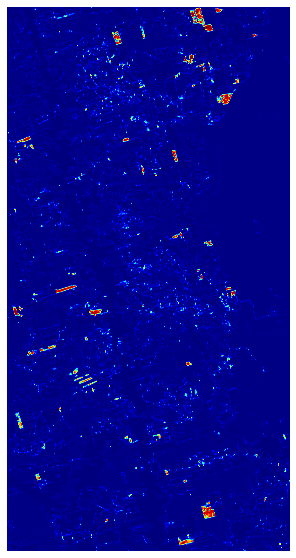

In [147]:
trainer.setMeanProbNotConsideredAreas()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [148]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0
    np.mean(value): 0.020787679
    np.max(value): 0.9725021


In [149]:
print(trainer.label_mask.shape)

(17730, 9200)


In [150]:
trainer.getLabelTest()

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [151]:
trainer.getMAP()

89.34


In [152]:
trainer.prob_rec.shape

(17760, 9216)

In [153]:
trainer.preprocessProbRec()
print(trainer.prob_rec.shape)

(17760, 9216, 1)


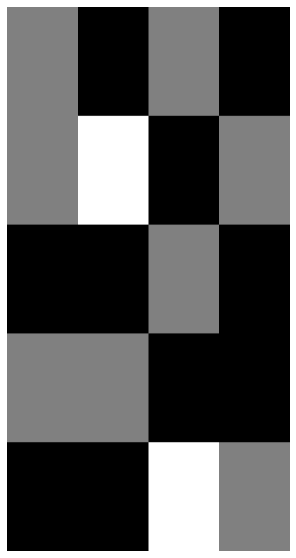

In [154]:
trainer.logger.plotFigure(trainer.mask_tr_val, 
            name=trainer.dataset.site + trainer.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [155]:
trainer.getLabelCurrentDeforestation()

In [156]:
trainer.applyProbabilityThreshold()

(17730, 9200)
(array([0., 1.], dtype=float32), array([161528210,   1587790], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [157]:
trainer.getTestValues()

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


In [158]:
trainer.removeSmallPolygons()

ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161528210,   1587790], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161660103,   1455897], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162984107,    131893], dtype=int64))


In [159]:
trainer.calculateMetrics()

ic| self.f1: 82.71, self.precision: 93.84, self.recall: 73.95


In [160]:
trainer.getValidationValuesForMetrics()
trainer.calculateMetricsValidation()

ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9436127,)
ic| f1_val: 83.04
    precision_val: 87.09
    recall_val: 79.35
    mAP_val: 86.28


In [161]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    trainer.calculateMAPWithoutSmallPolygons()

In [162]:
trainer.getErrorMask()

(array([0., 1.], dtype=float32), array([162486397,    629603], dtype=int64))


In [163]:
'''

import types

trainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)
'''


'\n\nimport types\n\ntrainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)\n'

In [164]:
trainer.getErrorMaskToShowRGB()

[0. 1.]


In [165]:
predicted_unpad_to_show = trainer.predicted_unpad.copy()

predicted_unpad_to_show[trainer.label_mask == 2] = 0
print(np.unique(predicted_unpad_to_show))

[0. 1.]


In [166]:
predicted_unpad_to_show.shape

(17730, 9200)

In [167]:

'''
trainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)
'''

'\ntrainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)\n'

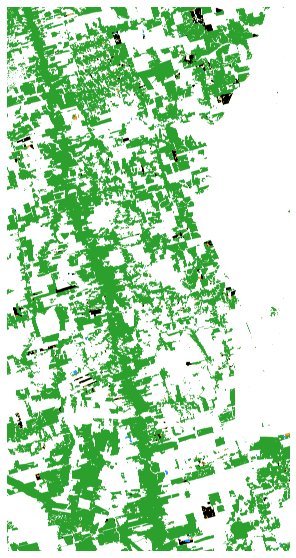

In [168]:
trainer.logger.plotFigure(trainer.error_mask_to_show_rgb[...,::-1], 
            name=trainer.dataset.site + trainer.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [169]:
trainer.setUncertainty()

In [170]:
trainer.getValidationValues2()
trainer.getTestValues2()

ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54172305,)


In [171]:
trainer.getUncertaintyToShow()
trainer.logger.getStats(trainer.uncertainty_to_show)


ic| np.min(value): 0.0, np.mean(value): 0.04099997, np.max(value): 1.0


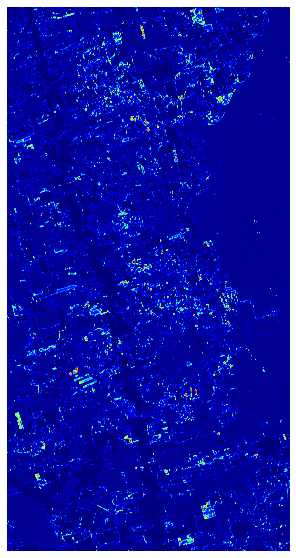

In [172]:
trainer.logger.plotFigure(trainer.uncertainty_to_show, 
            name=trainer.dataset.site + trainer.title_name + ' uncertainty evidential learning.png', figsize=(10,10), cmap='jet', savefig=True)

ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


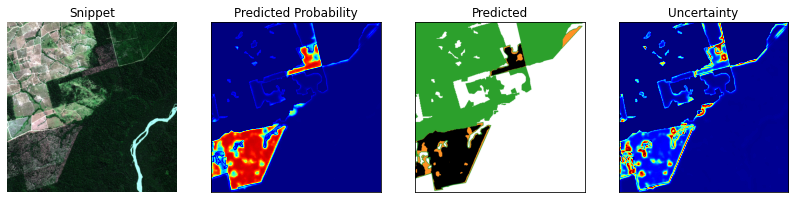

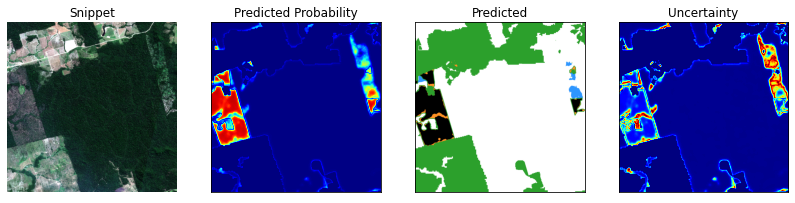

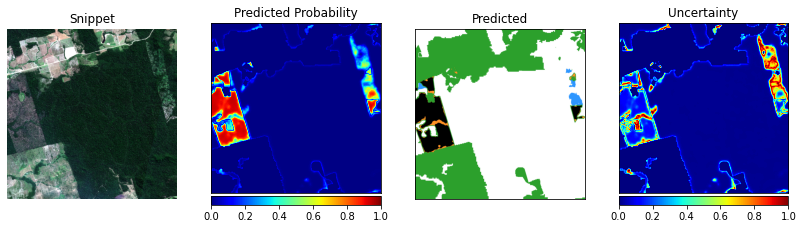

In [173]:
trainer.logger.plotCropSample(trainer)

In [174]:
trainer.logger.getStats(trainer.uncertainty)

ic| np.min(value): 0.009211045
    np.mean(value): 0.058322843
    np.max(value): 1.0


In [186]:
from sklearn import metrics

def getUncertaintyMetrics(self):
        predicted_thresholded = np.zeros_like(self.uncertainty).astype(np.int8)
        predicted_thresholded[self.uncertainty * 2 >= np.max(self.predicted_test,axis=-1)] = 1
        print(np.unique(predicted_thresholded, return_counts=True))

        predicted_test_classified_correct = self.predicted_test[
                predicted_thresholded == 0]
        label_current_deforestation_test_classified_correct = self.label_mask_current_deforestation_test[
                predicted_thresholded == 0]


        predicted_test_classified_incorrect = self.predicted_test[
                predicted_thresholded == 1]
        label_current_deforestation_test_classified_incorrect = self.label_mask_current_deforestation_test[
                predicted_thresholded == 1]

        uncertainty_classified_correct = self.uncertainty[
                predicted_thresholded == 0]
        uncertainty_classified_incorrect = self.uncertainty[
                predicted_thresholded == 1]
        print(np.min(uncertainty_classified_correct), np.mean(uncertainty_classified_correct), np.max(uncertainty_classified_correct))
        print(np.min(uncertainty_classified_incorrect), np.mean(uncertainty_classified_incorrect), np.max(uncertainty_classified_incorrect))

        print(label_current_deforestation_test_classified_correct.shape,
                predicted_test_classified_correct.shape)
        cm_correct = metrics.confusion_matrix(
                label_current_deforestation_test_classified_correct,
                predicted_test_classified_correct)
        print("cm_correct", cm_correct)

        TN_L = cm_correct[0,0]
        FN_L = cm_correct[1,0]
        TP_L = cm_correct[1,1]
        FP_L = cm_correct[0,1]

        ic(label_current_deforestation_test_classified_incorrect.shape,
                predicted_test_classified_incorrect.shape)

        cm_incorrect = metrics.confusion_matrix(
                label_current_deforestation_test_classified_incorrect,
                predicted_test_classified_incorrect)

        print("cm_incorrect", cm_incorrect)

        if cm_incorrect.shape[0] != 2: 
                ic(np.all(label_current_deforestation_test_classified_incorrect) == 0) 
                ic(np.all(predicted_test_classified_incorrect) == 0) 
                
                precision_L = np.nan 
                recall_L = np.nan 
                recall_Ltotal = np.nan 
                AA = len(label_current_deforestation_test_classified_incorrect) / len(self.label_mask_current_deforestation_test) 
                precision_H = np.nan 
                recall_H = np.nan 
        else:
                        
                TN_H = cm_incorrect[0,0]
                FN_H = cm_incorrect[1,0]
                TP_H = cm_incorrect[1,1]
                FP_H = cm_incorrect[0,1]
                
                precision_L = TP_L / (TP_L + FP_L)
                recall_L = TP_L / (TP_L + FN_L)
                
                precision_H = TP_H / (TP_H + FP_H)
                recall_H = TP_H / (TP_H + FN_H)
                
                recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
                ic((TP_H + FN_H + FP_H + TN_H), len(self.label_mask_current_deforestation_test))
                AA = (TP_H + FN_H + FP_H + TN_H) / len(self.label_mask_current_deforestation_test)
                ic((TP_H + FN_H + FP_H + TN_H), len(self.label_mask_current_deforestation_test))


        self.m = {'precision_L': precision_L,
                'recall_L': recall_L,
                'recall_Ltotal': recall_Ltotal,
                'AA': AA,
                'precision_H': precision_H,
                'recall_H': recall_H}

        self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
        self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])



In [187]:

import types

trainer.getUncertaintyMetrics = types.MethodType(getUncertaintyMetrics, trainer)


In [188]:
trainer.getUncertaintyMetrics()

(array([0, 1], dtype=int8), array([53990441,   181864], dtype=int64))
0.009211045 0.055150777 0.9999997
1.0 1.0 1.0
(53990441,) (53990441,)


ic| label_current_deforestation_test_classified_incorrect.shape: (181864,)
    predicted_test_classified_incorrect.shape: (181864,)
C:\Users\jchamorro\AppData\Local\Temp\ipykernel_6268\2552239376.py:67: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 181864
    len(self.label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 181864
    len(self.label_mask_current_deforestation_test): 54172305


cm_correct [[53254118    35787]
 [  155485   545051]]
cm_incorrect [[145323      0]
 [ 36541      0]]


In [177]:
trainer.getUncertaintyAAValues()

ic| self.uncertainty.shape: (54172305,)
    self.label_mask_current_deforestation_test.shape: (54172305,)


[0.13, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
threshold 0.13
(49380782,) (49380782,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4791523,)
    predicted_test_classified_incorrect.shape: (4791523,)


cm_correct [[49210753       37]
 [   15864   154128]]


ic| TP_H + FN_H + FP_H + TN_H: 4791523
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 4791523
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[4188688   35750]
 [ 176162  390923]]
[0.99976    0.90667796 0.20910705 0.08844968 0.91621218 0.68935521]
threshold 0.15
(49786598,) (49786598,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4385707,)
    predicted_test_classified_incorrect.shape: (4385707,)


cm_correct [[49560082      109]
 [   17063   209344]]


ic| TP_H + FN_H + FP_H + TN_H: 4385707
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 4385707
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[3839359   35678]
 [ 174963  335707]]
[0.9994796  0.92463572 0.28401917 0.08095847 0.90393258 0.6573854 ]
threshold 0.2
(50534706,) (50534706,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3637599,)
    predicted_test_classified_incorrect.shape: (3637599,)


cm_correct [[50228181      576]
 [   19757   286192]]


ic| TP_H + FN_H + FP_H + TN_H: 3637599
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 3637599
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[3171260   35211]
 [ 172269  258859]]
[0.99799141 0.93542388 0.38827965 0.06714868 0.8802632  0.60042261]
threshold 0.225
(50826924,) (50826924,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3345381,)
    predicted_test_classified_incorrect.shape: (3345381,)


cm_correct [[50494478      916]
 [   21031   310499]]


ic| TP_H + FN_H + FP_H + TN_H: 3345381
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 3345381
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[2904963   34871]
 [ 170995  234552]]
[0.99705859 0.93656381 0.42125721 0.06175445 0.87057155 0.5783596 ]
threshold 0.25
(51085277,) (51085277,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3087028,)
    predicted_test_classified_incorrect.shape: (3087028,)


cm_correct [[50731788     1456]
 [   22243   329790]]


ic| TP_H + FN_H + FP_H + TN_H: 3087028
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 3087028
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[2667653   34331]
 [ 169783  215261]]
[0.99560448 0.93681558 0.44742951 0.05698535 0.86245152 0.55905559]
threshold 0.27
(51271155,) (51271155,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2901150,)
    predicted_test_classified_incorrect.shape: (2901150,)


cm_correct [[50903026     1911]
 [   23184   343034]]


ic| TP_H + FN_H + FP_H + TN_H: 2901150
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 2901150
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[2496415   33876]
 [ 168842  202017]]
[0.99445999 0.93669344 0.46539778 0.05355412 0.85639252 0.54472724]
threshold 0.3
(51518175,) (51518175,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2654130,)
    predicted_test_classified_incorrect.shape: (2654130,)


cm_correct [[51130326     2491]
 [   24752   360606]]


ic| TP_H + FN_H + FP_H + TN_H: 2654130
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 2654130
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[2269115   33296]
 [ 167274  184445]]
[0.99313957 0.93576882 0.4892379  0.04899422 0.84708438 0.52441011]
threshold 0.34
(51804015,) (51804015,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2368290,)
    predicted_test_classified_incorrect.shape: (2368290,)


cm_correct [[51391574     3358]
 [   26959   382124]]


ic| TP_H + FN_H + FP_H + TN_H: 2368290
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 2368290
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[2007867   32429]
 [ 165067  162927]]
[0.99128883 0.93409895 0.51843159 0.04371773 0.83400049 0.49673775]
threshold 0.36
(51932841,) (51932841,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2239464,)
    predicted_test_classified_incorrect.shape: (2239464,)


cm_correct [[51508771     3863]
 [   28026   392181]]


ic| TP_H + FN_H + FP_H + TN_H: 2239464
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 2239464
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[1890670   31924]
 [ 164000  152870]]
[0.99024603 0.9333043  0.53207602 0.04133965 0.82724547 0.48243759]
threshold 0.45
(52422707,) (52422707,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1749598,)
    predicted_test_classified_incorrect.shape: (1749598,)
ic

cm_correct [[51948256     7525]
 [   32354   434572]]
cm_incorrect [[1451185   28262]
 [ 159672  110479]]


| TP_H + FN_H + FP_H + TN_H: 1749598
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1749598
    len(label_mask_current_deforestation_test): 54172305


[0.98297885 0.93070851 0.58958833 0.03229691 0.7962967  0.40895277]
threshold 0.55
(52835440,) (52835440,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1336865,)
    predicted_test_classified_incorrect.shape: (1336865,)
ic| TP_H + FN_H + FP_H + TN_H: 1336865
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1336865


cm_correct [[52307461    14875]
 [   36618   476486]]
cm_incorrect [[1091980   20912]
 [ 155408   68565]]


    len(label_mask_current_deforestation_test): 54172305


[0.96972694 0.92863435 0.64645349 0.02467802 0.76628631 0.30613065]
threshold 0.65
(53180655,) (53180655,)


ic| label_current_deforestation_test_classified_incorrect.shape: (991650,)
    predicted_test_classified_incorrect.shape: (991650,)
ic| TP_H + FN_H + FP_H + TN_H: 991650
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 991650
    len(label_mask_current_deforestation_test): 54172305


cm_correct [[52601008    23950]
 [   42575   513122]]
cm_incorrect [[798433  11837]
 [149451  31929]]
[0.95540635 0.92338451 0.69615793 0.01830548 0.72953891 0.17603374]
threshold 0.8
(53606086,) (53606086,)


ic| label_current_deforestation_test_classified_incorrect.shape: (566219,)
    predicted_test_classified_incorrect.shape: (566219,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 566219
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 566219
    len(label_mask_current_deforestation_test): 54172305


cm_correct [[52949067    35787]
 [   76181   545051]]
cm_incorrect [[450374      0]
 [115845      0]]
[0.9383873  0.87737109 0.73947634 0.01045219        nan 0.        ]


In [178]:
trainer.getUncertaintyAAAuditedValues()

ic| self.uncertainty.shape: (54172305,)
    self.label_mask_current_deforestation_test.shape: (54172305,)


threshold 0.13
(54172305,) (54172305,)
cm_audited [[53435191       37]
 [   15864   721213]]
[0.9999487  0.97847715]
threshold 0.15
(54172305,) (54172305,)
cm_audited [[53435119      109]
 [   17063   720014]]
[0.99984864 0.97685045]
threshold 0.2
(54172305,) (54172305,)
cm_audited [[53434652      576]
 [   19757   717320]]
[0.99919766 0.97319547]
threshold 0.225
(54172305,) (54172305,)
cm_audited [[53434312      916]
 [   21031   716046]]
[0.99872239 0.97146702]
threshold 0.25
(54172305,) (54172305,)
cm_audited [[53433772     1456]
 [   22243   714834]]
[0.9979673  0.96982269]
threshold 0.27
(54172305,) (54172305,)
cm_audited [[53433317     1911]
 [   23184   713893]]
[0.99733027 0.96854603]
threshold 0.3
(54172305,) (54172305,)
cm_audited [[53432737     2491]
 [   24752   712325]]
[0.99651519 0.96641871]
threshold 0.34
(54172305,) (54172305,)
cm_audited [[53431870     3358]
 [   26959   710118]]
[0.99529346 0.96342445]
threshold 0.36
(54172305,) (54172305,)
cm_audited [[53431365     

ic| metric_values_audited: array([[0.9999487 , 0.97847715],
                                  [0.99984864, 0.97685045],
                                  [0.99919766, 0.97319547],
                                  [0.99872239, 0.97146702],
                                  [0.9979673 , 0.96982269],
                                  [0.99733027, 0.96854603],
                                  [0.99651519, 0.96641871],
                                  [0.99529346, 0.96342445],
                                  [0.99458139, 0.96197684],
                                  [0.98943486, 0.95610499],
                                  [0.97920552, 0.95031998],
                                  [0.96666444, 0.94223806],
                                  [0.9486323 , 0.89664445]])


cm_audited [[53399441    35787]
 [   76181   660896]]
[0.9486323  0.89664445]


In [179]:
trainer.setPlotLimsForUncertaintyAA()

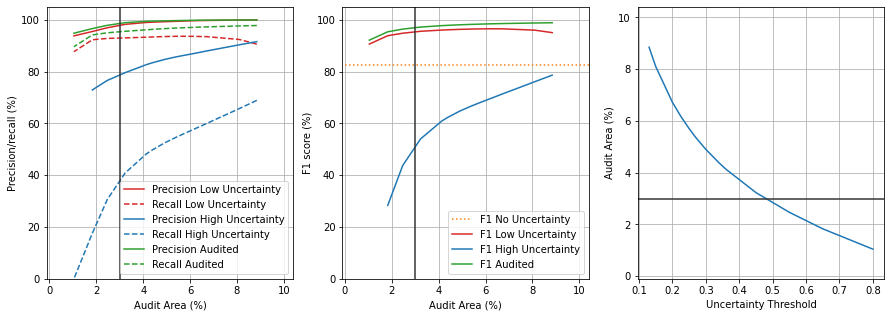

In [180]:
trainer.plotUncertaintyAA()

In [181]:
trainer.getOptimalUncertaintyThreshold()

ic| bounds: (0.0015, 0.9985)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.38232011321635484
threshold 0.38232011321635484
(52067767,) (52067767,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2104538,)
    predicted_test_classified_incorrect.shape: (2104538,)


cm_correct [[51631041     4507]
 [   29120   403099]]


ic| TP_H + FN_H + FP_H + TN_H: 2104538
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 2104538
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[1768400   31280]
 [ 162906  141952]]
[0.98894275 0.93262675 0.54688859 0.03884897 0.8194329  0.46563318]
0.6176798867836452
threshold 0.6176798867836452
(53073414,) (53073414,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1098891,)
    predicted_test_classified_incorrect.shape: (1098891,)
ic| TP_H + FN_H + FP_H + TN_H: 1098891
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1098891
    len(label_mask_current_deforestation_test): 54172305


cm_correct [[52510708    20675]
 [   40290   501741]]
cm_incorrect [[888733  15112]
 [151736  43310]]
[0.96042426 0.92566846 0.68071721 0.02028511 0.74133032 0.22205018]
0.23685977356729035
threshold 0.23685977356729035
(50953180,) (50953180,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3219125,)
    predicted_test_classified_incorrect.shape: (3219125,)


cm_correct [[50610337     1174]
 [   21611   320058]]


ic| TP_H + FN_H + FP_H + TN_H: 3219125
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 3219125
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[2789104   34613]
 [ 170415  224993]]
[0.99634532 0.93674872 0.434226   0.05942381 0.86667103 0.56901479]
0.49517280107016803
threshold 0.49517280107016803
(52622141,) (52622141,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1550164,)
    predicted_test_classified_incorrect.shape: (1550164,)
ic

cm_correct [[52123378    10550]
 [   34181   454032]]
cm_incorrect [[1276063   25237]
 [ 157845   91019]]


| TP_H + FN_H + FP_H + TN_H: 1550164
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1550164
    len(label_mask_current_deforestation_test): 54172305


[0.97729141 0.92998753 0.61598992 0.02861543 0.78291873 0.36573791]
0.49677233692305195
threshold 0.49677233692305195
(52628705,) (52628705,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1543600,)
    predicted_test_classified_incorrect.shape: (1543600,)
ic

cm_correct [[52129139    10668]
 [   34234   454664]]
cm_incorrect [[1270302   25119]
 [ 157792   90387]]


| TP_H + FN_H + FP_H + TN_H: 1543600
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1543600
    len(label_mask_current_deforestation_test): 54172305


[0.97707443 0.92997721 0.61684736 0.02849426 0.78253078 0.36420084]
0.465421727775799
threshold 0.465421727775799
(52493950,) (52493950,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1678355,)
    predicted_test_classified_incorrect.shape: (1678355,)
ic

cm_correct [[52011077     8496]
 [   32955   441422]]
cm_incorrect [[1388364   27291]
 [ 159071  103629]]


| TP_H + FN_H + FP_H + TN_H: 1678355
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1678355
    len(label_mask_current_deforestation_test): 54172305


[0.98111656 0.93052994 0.5988818  0.03098179 0.79154445 0.39447659]
0.43367973553408445
threshold 0.43367973553408445
(52344169,) (52344169,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1828136,)
    predicted_test_classified_incorrect.shape: (1828136,)


cm_correct [[51878663     6648]
 [   31588   427270]]


ic| TP_H + FN_H + FP_H + TN_H: 1828136
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1828136
    len(label_mask_current_deforestation_test): 54172305


cm_incorrect [[1520778   29139]
 [ 160438  117781]]
[0.98467913 0.93115953 0.57968163 0.03374669 0.80166757 0.42333917]
0.4768862289160707
threshold 0.4768862289160707
(52544635,) (52544635,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1627670,)
    predicted_test_classified_incorrect.shape: (1627670,)
ic

cm_correct [[52055527     9236]
 [   33428   446444]]
cm_incorrect [[1343914   26551]
 [ 158598   98607]]


| TP_H + FN_H + FP_H + TN_H: 1627670
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1627670
    len(label_mask_current_deforestation_test): 54172305


[0.97973139 0.93033976 0.6056952  0.03004616 0.78786014 0.38337902]
0.47899631768354883
threshold 0.47899631768354883
(52553832,) (52553832,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1618473,)
    predicted_test_classified_incorrect.shape: (1618473,)
ic

cm_correct [[52063640     9396]
 [   33515   447281]]
cm_incorrect [[1335801   26391]
 [ 158511   97770]]


| TP_H + FN_H + FP_H + TN_H: 1618473
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1618473
    len(label_mask_current_deforestation_test): 54172305


[0.97942528 0.93029268 0.60683077 0.02987639 0.78744533 0.38149531]
0.4758357895159788
threshold 0.4758357895159788
(52540039,) (52540039,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1632266,)
    predicted_test_classified_incorrect.shape: (1632266,)
ic

cm_correct [[52051487     9169]
 [   33383   446000]]
cm_incorrect [[1347954   26618]
 [ 158643   99051]]


| TP_H + FN_H + FP_H + TN_H: 1632266
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1632266
    len(label_mask_current_deforestation_test): 54172305


[0.97985583 0.93036257 0.60509282 0.03013101 0.78818961 0.38437449]
0.47744753773657206
threshold 0.47744753773657206
(52547022,) (52547022,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1625283,)
    predicted_test_classified_incorrect.shape: (1625283,)
ic

cm_correct [[52057625     9283]
 [   33447   446667]]
cm_incorrect [[1341816   26504]
 [ 158579   98384]]


| TP_H + FN_H + FP_H + TN_H: 1625283
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1625283
    len(label_mask_current_deforestation_test): 54172305


[0.97964031 0.9303353  0.60599775 0.0300021  0.78777785 0.38287224]
0.47769456500179774
threshold 0.47769456500179774
(52548115,) (52548115,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624190,)
    predicted_test_classified_incorrect.shape: (1624190,)


cm_correct [[52058593     9307]
 [   33455   446760]]
cm_incorrect [[1340848   26480]
 [ 158571   98291]]


ic| TP_H + FN_H + FP_H + TN_H: 1624190
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1624190
    len(label_mask_current_deforestation_test): 54172305


[0.97959291 0.93033329 0.60612392 0.02998193 0.7877712  0.38266073]
0.4773885026278382
threshold 0.4773885026278382
(52546775,) (52546775,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1625530,)
    predicted_test_classified_incorrect.shape: (1625530,)
ic

cm_correct [[52057417     9276]
 [   33445   446637]]
cm_incorrect [[1342024   26511]
 [ 158581   98414]]


| TP_H + FN_H + FP_H + TN_H: 1625530
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1625530
    len(label_mask_current_deforestation_test): 54172305


[0.97965401 0.93033482 0.60595704 0.03000666 0.78778467 0.3829413 ]
0.47750131553507524
threshold 0.47750131553507524
(52547245,) (52547245,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1625060,)
    predicted_test_classified_incorrect.shape: (1625060,)
ic

cm_correct [[52057826     9288]
 [   33447   446684]]
cm_incorrect [[1341615   26499]
 [ 158579   98367]]


| TP_H + FN_H + FP_H + TN_H: 1625060
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1625060
    len(label_mask_current_deforestation_test): 54172305


[0.97963033 0.93033776 0.60602081 0.02999799 0.7877805  0.38283141]
0.47753465595089767
threshold 0.47753465595089767
(52547407,) (52547407,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624898,)
    predicted_test_classified_incorrect.shape: (1624898,)
ic

cm_correct [[52057974     9291]
 [   33447   446695]]
cm_incorrect [[1341467   26496]
 [ 158579   98356]]


| TP_H + FN_H + FP_H + TN_H: 1624898
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1624898
    len(label_mask_current_deforestation_test): 54172305
ic| self.threshold_optimal: 0.47750131553507524


[0.97962437 0.93033936 0.60603573 0.02999499 0.78778073 0.38280499]


In [182]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.47750131553507524
(52547245,) (52547245,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1625060,)
    predicted_test_classified_incorrect.shape: (1625060,)
ic

cm_correct [[52057826     9288]
 [   33447   446684]]
cm_incorrect [[1341615   26499]
 [ 158579   98367]]


| TP_H + FN_H + FP_H + TN_H: 1625060
    len(label_mask_current_deforestation_test): 54172305
ic| TP_H + FN_H + FP_H + TN_H: 1625060
    len(label_mask_current_deforestation_test): 54172305


[0.97963033 0.93033776 0.60602081 0.02999799 0.7877805  0.38283141]
threshold 0.47750131553507524
(54172305,) (54172305,)


ic| self.m_optimal: {'AA': array([0.02999799]),
                     'f1': 82.71,
                     'f1_H': array([0.51526406]),
                     'f1_L': array([0.95434797]),
                     'precision_H': array([0.7877805]),
                     'precision_L': array([0.97963033]),
                     'recall_H': array([0.38283141]),
                     'recall_L': array([0.93033776]),
                     'recall_Ltotal': array([0.60602081])}
ic| self.m_audited_optimal: {'f1': array([0.97052748]),
                             'precision': array([0.98697185]),
                             'recall': array([0.95462211])}


cm_audited [[53425940     9288]
 [   33447   703630]]
[0.98697185 0.95462211]


{'metrics': {'precision_L': array([0.97963033]),
  'recall_L': array([0.93033776]),
  'recall_Ltotal': array([0.60602081]),
  'AA': array([0.02999799]),
  'precision_H': array([0.7877805]),
  'recall_H': array([0.38283141]),
  'f1_L': array([0.95434797]),
  'f1_H': array([0.51526406]),
  'f1': 82.71},
 'metrics_audited': {'precision': array([0.98697185]),
  'recall': array([0.95462211]),
  'f1': array([0.97052748])},
 'exp': 176}